In [2]:
%matplotlib inline
import pandas as pd

In [3]:
df = pd.read_csv('metal.csv', delimiter=';', index_col='Unnamed: 0')

In [4]:
(df['ngram1'] + df['ngram2'] + df['pubyear'].map(str)).value_counts().value_counts()

1    175572
dtype: int64

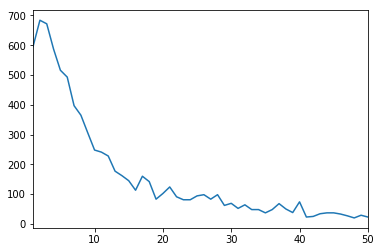

In [5]:
df['ngram1'].append(df['ngram2']).value_counts().value_counts().sort_index()[:50].plot()

In [6]:
subdf = df[df['pubyear'] == 2011]
pd.DataFrame({
    'Source': subdf['ngram1'],
    'Target': subdf['ngram2'],
    'Weight': subdf['count'],
}).to_csv('metal_graph_2011.csv')

In [7]:
df['pubyear'].value_counts()

2011    52757
2014    39965
2013    31674
2015    30743
2012    20433
Name: pubyear, dtype: int64

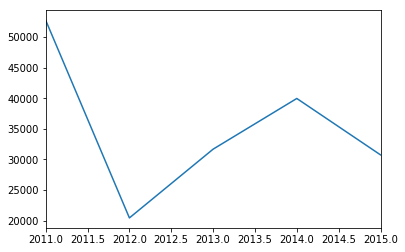

In [8]:
df['pubyear'].value_counts().sort_index().plot()

In [9]:
df['count'].value_counts().sort_index()

1      110800
2       33888
3       10378
4        7093
5        3277
6        2374
7        1394
8        1223
9         810
10        734
11        476
12        411
13        336
14        258
15        178
16        172
17        165
18        149
19        125
20        110
21        113
22         89
23         83
24         64
25         44
26         48
27         60
28         44
29         36
30         42
        ...  
145         1
147         1
152         1
154         1
155         1
156         1
157         1
159         1
160         1
161         1
162         2
164         2
165         3
166         1
168         1
172         3
174         2
177         1
180         1
181         1
194         1
200         1
201         2
205         1
212         1
214         1
222         1
225         1
244         1
268         1
Name: count, dtype: int64

In [11]:
pairs = df['ngram1'] + ' + ' + df['ngram2']

In [12]:
len(pairs)

175572

In [13]:
len(pairs.value_counts())

141085

In [14]:
pairs.value_counts().value_counts()

1    119192
2     14517
3      3869
4      1796
5      1711
dtype: int64

In [15]:
len(df)

175572

## Metal 2

In [19]:
metal_2 = df[['ngram1', 'ngram2', 'count']]
metal_2 = metal_2[metal_2['count'] >= 2]
metal_2 = metal_2.groupby(['ngram1', 'ngram2']).sum()
metal_2 = metal_2.reset_index()

In [20]:
metal_2_nodes = sorted(set(metal_2['ngram1']).union(set(metal_2['ngram2'])))

In [21]:
len(metal_2_nodes)

6572

In [35]:
values_order = ('total', '2011', '2012', '2013', '2014', '2015')
metal_2_values = [[0] * len(values_order) for node in metal_2_nodes]
metal_2_nodes_rev = {label: pos for pos, label in enumerate(metal_2_nodes)}
for _, row in df.iterrows():
    count = row['count']
    year = row['pubyear']
    for ngram in row['ngram1'], row['ngram2']:
        if ngram not in metal_2_nodes_rev:
            continue
        node_id = metal_2_nodes_rev[ngram]
        node_values = metal_2_values[node_id]
        node_values[values_order.index('total')] += count
        node_values[values_order.index(str(year))] += count

In [37]:
for row in metal_2_values:
    assert sum(row) == row[0] * 2
    
metal_2_total_values = [0] * len(values_order)
for row in metal_2_values:
    for no, val in enumerate(row):
        metal_2_total_values[no] += val
metal_2_total_values

[756418, 235757, 75029, 132686, 179193, 133753]

In [98]:
raise
import csv
pd.DataFrame({
    'Source': metal_2['ngram1'],
    'Target': metal_2['ngram2'],
    'Weight': metal_2['count'],
}).to_csv('metal_2_graph.csv', index=False, quoting=csv.QUOTE_ALL)

## Graph

In [25]:
label = None
coords = {}
for line in open('./metal_2_graph_positions.graphml'):
    if line.startswith('<data key="label">'):
        label = line[line.index('>') + 1:line.index('<', 1)]
        label = label.replace('&amp;', '&')
        x = None
        y = None
    if line.startswith('<data key="x">'):
        assert x is None
        x = line[line.index('>') + 1:line.index('<', 1)]
    if line.startswith('<data key="y">'):
        assert y is None
        y = line[line.index('>') + 1:line.index('<', 1)]
        coords[label] = (x, y)
        label = None

metal_2_coords = []
for label in metal_2_nodes:
    x, y = coords[label]
    metal_2_coords.append(float(x))
    metal_2_coords.append(float(y))

## JSON

In [32]:
edges = []
for _, row in metal_2.iterrows():
    edges.append(metal_2_nodes.index(row['ngram1']))
    edges.append(metal_2_nodes.index(row['ngram2']))
    edges.append(row['count'])

In [38]:
import json

res = {
    'node_count': len(metal_2_nodes),
    'values_order': values_order,
    'total_values': metal_2_total_values,
    'values': [item for row in metal_2_values for item in row],
    'labels': metal_2_nodes,
    'coords': metal_2_coords,
    'edges': edges
}
json.dump(res, open('metal_2.json', 'w'))